<h1>Problem 3: [25 points]</h1>
You will extend Dquad to handle deletions.

Next, we explain how to execute the deletion: Let initially your data structure Dquad 
was constructed over the set P of n points. For the first n/2 deletions you perform the 
following steps: Let x be the point we want to delete. We find the leaf node that contains 
x. We remove x from the leaf node and we update the representative points in the path 
from the leaf node to the root, accordingly, if needed. For example, if an inner node of 
the quadtree has x as its representative point, this should be changed and take a different 
representative point. If there are no other points available to find one new representative 
then the node becomes inactive. Notice that the structure of the tree does not change at 
all. When the n/2 + 1 deletion is requested, we delete the current tree, and we construct 
from scratch a new quad tree with the remaining points in the data set, updating n to the 
remaining number of points in the dataset. Next, we start performing deletions, as we 
explained above (from scratch).

Delete all the input points from the box [450, 550] × [450, 550]. What is the average 
deletion time? Run the ε-NN query q₀ = (500, 500) and re-create the figure from Problem 2, 
for each ε on the x-axis. Explain the results.

Delete all the input points from the box [900, 1000] × [900, 1000]. What is the average 
deletion time? Run the ε-NN query q₁ = (1000, 1000) and re-create the figure from Problem 
2, for each ε on the x-axis. Explain the results.

Delete more points from the data set until your tree needs to be re-constructed. Re-
construct the tree and delete 1000 more points (any points you want). What is the average 
deletion time? Recompute the figures for q₁ and q₂. Explain the results. How many points 
are still stored in the data structure?

Next, fix ε = 0.1 and run 1000 random queries in the box [0, 1000] × [0, 1000]. Show the 
average query time and the average distance of the query with the point returned by you 
data structure. Explain the results and compare with the results from the same experiment 
in Problem 2.

Next, fix ε = 0.1 and run 1000 random queries in the box [1000, 1500] × [1000, 1500]. 
Show the average query time and the average distance of the query with the point returned 
by you data structure. Explain the results and compare with the results from the same 
experiment in Problem 2.

In [1]:
#Question 3
import numpy as np
from queue import Queue
import matplotlib.pyplot as plt
import time


In [2]:

class QuadNode:
    def __init__(self, center, width):
        self.center = center
        self.width = width
        self.point = None
        self.children = None
        self.is_active = True

    def get_diameter(self):
        return 2 * self.width



In [3]:
class QuadTree:
    def __init__(self, points):
        self.points = points.copy()
        self.n = len(points)
        self.deletion_count = 0
        self.dim = points.shape[1]
        self.min_coords = np.min(points, axis=0)
        self.max_coords = np.max(points, axis=0)
        self.center = (self.min_coords + self.max_coords) / 2
        self.width = np.max(self.max_coords - self.min_coords) / 2
        self.root = self.build_tree(points, self.center, self.width)

    def build_tree(self, points, center, width):
        node = QuadNode(center, width)
        if len(points) <= 1:
            if len(points) == 1:
                node.point = points[0]
            return node

        node.children = []
        for i in range(2 ** self.dim):
            child_center = center.copy()
            for d in range(self.dim):
                offset = width / 2 if (i & (1 << d)) else -width / 2
                child_center[d] += offset

            mask = np.ones(len(points), dtype=bool)
            for d in range(self.dim):
                if i & (1 << d):
                    mask &= points[:, d] >= center[d]
                else:
                    mask &= points[:, d] < center[d]

            child_points = points[mask]
            node.children.append(self.build_tree(child_points, child_center, width/2))

        for child in node.children:
            if child.point is not None:
                node.point = child.point
                break

        return node

    def find_point_node(self, point, node=None):
        if node is None:
            node = self.root
        
        if node.point is not None and np.array_equal(node.point, point):
            return node
            
        if node.children is not None:
            for child in node.children:
                result = self.find_point_node(point, child)
                if result is not None:
                    return result
        return None

    def find_new_representative(self, node):
        if node.children is None:
            return None
        
        for child in node.children:
            if child.point is not None and child.is_active:
                return child.point
            rep = self.find_new_representative(child)
            if rep is not None:
                return rep
        return None

    def find_parent(self, target_node, parent=None, current_node=None):
        if current_node is None:
            current_node = self.root
            
        if current_node == target_node:
            return parent
            
        if current_node.children:
            for child in current_node.children:
                result = self.find_parent(target_node, current_node, child)
                if result is not None:
                    return result
        return None

    def delete_point(self, point):
        self.deletion_count += 1
        
        if self.deletion_count > self.n // 2:
            remaining_points = []
            for p in self.points:
                if not any(np.array_equal(p, d_point) for d_point in deleted_points):
                    remaining_points.append(p)
            self.points = np.array(remaining_points)
            self.n = len(self.points)
            self.deletion_count = 0
            self.root = self.build_tree(self.points, self.center, self.width)
            return True
            
        node = self.find_point_node(point)
        if node is not None:
            node.point = None
            node.is_active = False
            
            current = node
            while current is not None:
                if current.point is not None and np.array_equal(current.point, point):
                    new_rep = self.find_new_representative(current)
                    current.point = new_rep
                    if new_rep is None:
                        current.is_active = False
                current = self.find_parent(current)
            return True
        return False

    def ann_search(self, query, epsilon):
        Q = Queue()
        Q.put(self.root)
        p_curr = self.root.point if self.root.point is not None and self.root.is_active else None
        r_curr = float('inf') if p_curr is None else np.linalg.norm(query - p_curr)

        while not Q.empty():
            u = Q.get()

            if u.point is not None and u.is_active:
                dist = np.linalg.norm(query - u.point)
                if dist < r_curr:
                    r_curr = dist
                    p_curr = u.point

            if u.children is not None:
                dist_to_cell = np.linalg.norm(query - u.center)
                if dist_to_cell - u.get_diameter() <= (2 - epsilon/2) * r_curr:
                    for child in u.children:
                        if child.is_active:
                            Q.put(child)

        return p_curr, r_curr



In [4]:
points = np.loadtxt('Pquad.txt', skiprows=1, delimiter=',')
tree = QuadTree(points)
deleted_points = []

deletion_times_1 = []
for point in points:
    if 450 <= point[0] <= 550 and 450 <= point[1] <= 550:
        start_time = time.time()
        tree.delete_point(point)
        deletion_times_1.append(time.time() - start_time)
        deleted_points.append(point)

print(f"First region - Points deleted: {len(deletion_times_1)}")
print(f"Average deletion time: {np.mean(deletion_times_1)*1000:.2f} ms")

deletion_times_2 = []
for point in points:
    if 900 <= point[0] <= 1000 and 900 <= point[1] <= 1000:
        start_time = time.time()
        tree.delete_point(point)
        deletion_times_2.append(time.time() - start_time)
        deleted_points.append(point)

print(f"\nSecond region - Points deleted: {len(deletion_times_2)}")
print(f"Average deletion time: {np.mean(deletion_times_2)*1000:.2f} ms")



First region - Points deleted: 108
Average deletion time: 40.73 ms

Second region - Points deleted: 112
Average deletion time: 78.74 ms



Results for q0:
ε=0.05: distance=50.68, point=[493.72 449.71]
ε=0.10: distance=50.68, point=[493.72 449.71]
ε=0.15: distance=50.68, point=[493.72 449.71]
ε=0.20: distance=50.68, point=[493.72 449.71]
ε=0.25: distance=50.68, point=[493.72 449.71]


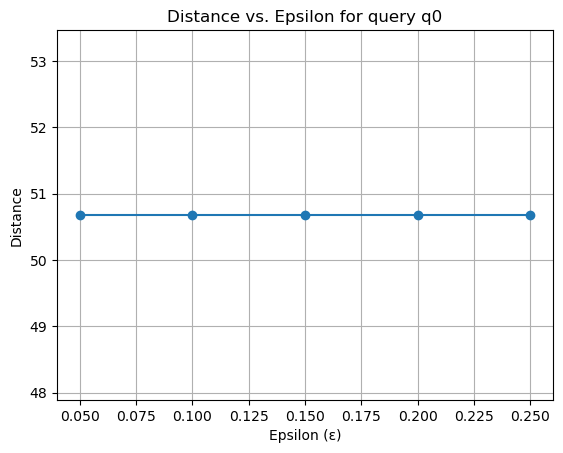


Results for q1:
ε=0.05: distance=501.64, point=[994.15 498.39]
ε=0.10: distance=501.64, point=[994.15 498.39]
ε=0.15: distance=501.64, point=[994.15 498.39]
ε=0.20: distance=501.64, point=[994.15 498.39]
ε=0.25: distance=501.64, point=[994.15 498.39]


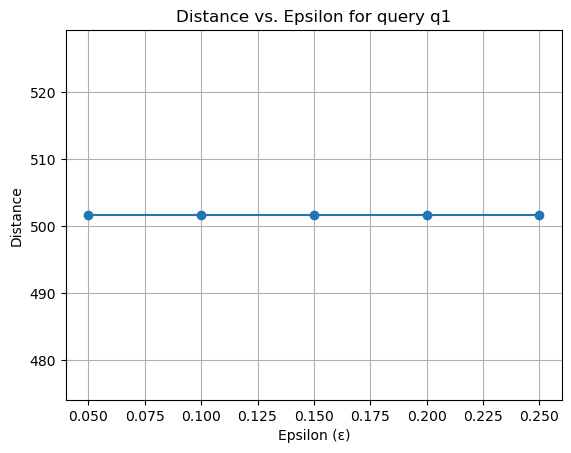

In [5]:
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]

q0 = np.array([500, 500])
q1 = np.array([1000, 1000])

def plot_query_results(query, epsilons, tree, query_name):
    distances = []
    points = []
    for epsilon in epsilons:
        point, distance = tree.ann_search(query, epsilon)  # Get both point and distance
        distances.append(distance)
        points.append(point)  # Store the returned point
    
    for eps, dist, point in zip(epsilons, distances, points):  # Use points from ann_search
        print(f"ε={eps:.2f}: distance={dist:.2f}, point={point}")

    plt.figure()
    plt.plot(epsilons, distances, marker='o')
    plt.xlabel("Epsilon (\u03b5)")
    plt.ylabel("Distance")
    plt.title(f"Distance vs. Epsilon for query {query_name}")
    plt.grid(True)
    plt.show()



print("\nResults for q0:")
plot_query_results(q0, epsilons, tree, "q0")

print("\nResults for q1:")
plot_query_results(q1, epsilons, tree, "q1")


Reconstruction trigger - Points deleted: 4670
Average deletion time: 36.51 ms

Post-reconstruction - Points deleted: 1000
Average deletion time: 121.55 ms

Remaining points in data structure: 4109

Results for q0 after all deletions:
ε=0.05: distance=57.82, point=[510.18 443.08]
ε=0.10: distance=57.82, point=[510.18 443.08]
ε=0.15: distance=57.82, point=[510.18 443.08]
ε=0.20: distance=57.82, point=[510.18 443.08]
ε=0.25: distance=57.82, point=[510.18 443.08]


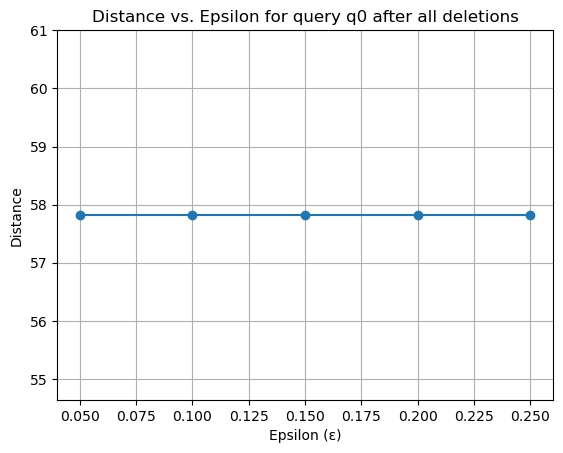


Results for q1 after all deletions:
ε=0.05: distance=110.22, point=[894.07 969.55]
ε=0.10: distance=110.22, point=[894.07 969.55]
ε=0.15: distance=110.22, point=[894.07 969.55]
ε=0.20: distance=110.22, point=[894.07 969.55]
ε=0.25: distance=110.22, point=[894.07 969.55]


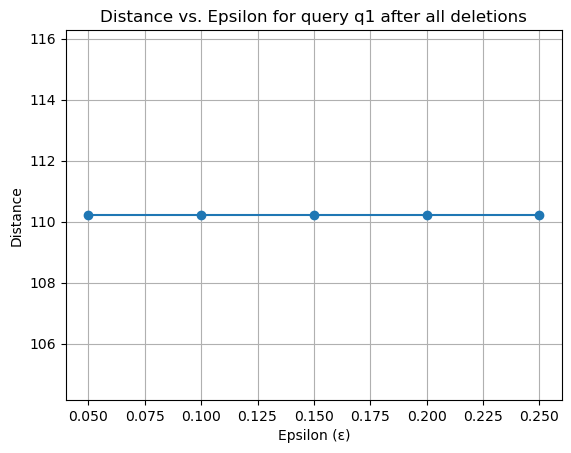

In [6]:

# Continue deleting points until tree reconstruction is needed
deletion_times_3 = []
points_to_delete = []
remaining_count = len(points) - len(deleted_points)
points_needed = (remaining_count // 2) + 1 - len(deleted_points)  # Calculate how many more deletions needed to trigger reconstruction

# Select additional points to delete to trigger reconstruction
count = 0
for point in points:
    if count >= points_needed:
        break
    if not any(np.array_equal(point, d_point) for d_point in deleted_points):
        points_to_delete.append(point)
        count += 1

# Delete points until reconstruction
for point in points_to_delete:
    start_time = time.time()
    tree.delete_point(point)
    deletion_times_3.append(time.time() - start_time)
    deleted_points.append(point)

print(f"\nReconstruction trigger - Points deleted: {len(deletion_times_3)}")
print(f"Average deletion time: {np.mean(deletion_times_3)*1000:.2f} ms")

# Delete 1000 more random points after reconstruction
deletion_times_4 = []
points_to_delete = []
count = 0
for point in points:
    if count >= 1000:
        break
    if not any(np.array_equal(point, d_point) for d_point in deleted_points):
        points_to_delete.append(point)
        count += 1

for point in points_to_delete:
    start_time = time.time()
    tree.delete_point(point)
    deletion_times_4.append(time.time() - start_time)
    deleted_points.append(point)

print(f"\nPost-reconstruction - Points deleted: {len(deletion_times_4)}")
print(f"Average deletion time: {np.mean(deletion_times_4)*1000:.2f} ms")

# Calculate remaining points
remaining_points = len(points) - len(deleted_points)
print(f"\nRemaining points in data structure: {remaining_points}")

# Recompute figures for q0 and q1 after all deletions
print("\nResults for q0 after all deletions:")
plot_query_results(q0, epsilons, tree, "q0 after all deletions")

print("\nResults for q1 after all deletions:")
plot_query_results(q1, epsilons, tree, "q1 after all deletions")





In [7]:

np.random.seed(42)
num_queries = 1000
epsilon = 0.1
queries_1 = np.random.uniform(0, 1000, size=(num_queries, 2))

times_1 = []
distances_1 = []

for query in queries_1:
    start_time = time.time()
    _, distance = tree.ann_search(query, epsilon)
    query_time = time.time() - start_time
    times_1.append(query_time)
    distances_1.append(distance)

print("\nResults for [0,1000]×[0,1000]:")
print(f"Average query time: {np.mean(times_1)*1000:.2f} ms")
print(f"Average distance: {np.mean(distances_1):.2f}")
print(f"Min distance: {min(distances_1):.2f}")
print(f"Max distance: {max(distances_1):.2f}")




Results for [0,1000]×[0,1000]:
Average query time: 1.80 ms
Average distance: 24.05
Min distance: 0.35
Max distance: 210.24


In [8]:
queries_2 = np.random.uniform(1000, 1500, size=(num_queries, 2))
times_2 = []
distances_2 = []

for query in queries_2:
    start_time = time.time()
    _, distance = tree.ann_search(query, epsilon)
    query_time = time.time() - start_time
    times_2.append(query_time)
    distances_2.append(distance)

print("\nResults for [1000,1500]×[1000,1500]:")
print(f"Average query time: {np.mean(times_2)*1000:.2f} ms")
print(f"Average distance: {np.mean(distances_2):.2f}")
print(f"Min distance: {min(distances_2):.2f}")
print(f"Max distance: {max(distances_2):.2f}")


Results for [1000,1500]×[1000,1500]:
Average query time: 12.15 ms
Average distance: 455.50
Min distance: 113.96
Max distance: 781.27
